In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [31]:
# PART 1: Data Loading and Preprocessing

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define basic transform (no augmentation for baseline model)
transform = transforms.Compose([transforms.ToTensor()])

# Download FashionMNIST dataset
train_val_data = datasets.FashionMNIST(
    root='data', train=True, download=True, transform=transform
)
test_data = datasets.FashionMNIST(
    root='data', train=False, download=True, transform=transform
)

# Split into 80% training (48,000) and 20% validation (12,000)
train_size = int(0.8 * len(train_val_data))
val_size = len(train_val_data) - train_size
train_data, val_data = random_split(train_val_data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


Using device: cpu


In [32]:
# PART 2: Baseline CNN Definition
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)# Reduces to 32x14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten_dim = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, 10) # 10 output classes

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 1, 28, 28)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, loss, and optimizer
model = BaselineCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [33]:
# PART 3: Training and Validation Loop
# Training and validation loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")


Epoch 1/10: Train Loss=0.5112, Train Acc=81.43%, Val Loss=0.3451, Val Acc=87.80%
Epoch 2/10: Train Loss=0.3270, Train Acc=88.17%, Val Loss=0.2872, Val Acc=89.58%
Epoch 3/10: Train Loss=0.2756, Train Acc=89.96%, Val Loss=0.2723, Val Acc=90.29%
Epoch 4/10: Train Loss=0.2413, Train Acc=91.09%, Val Loss=0.2558, Val Acc=90.71%
Epoch 5/10: Train Loss=0.2199, Train Acc=92.02%, Val Loss=0.2327, Val Acc=91.66%
Epoch 6/10: Train Loss=0.1942, Train Acc=92.87%, Val Loss=0.2402, Val Acc=91.56%
Epoch 7/10: Train Loss=0.1760, Train Acc=93.45%, Val Loss=0.2323, Val Acc=91.63%
Epoch 8/10: Train Loss=0.1598, Train Acc=94.08%, Val Loss=0.2214, Val Acc=92.22%
Epoch 9/10: Train Loss=0.1419, Train Acc=94.73%, Val Loss=0.2240, Val Acc=92.19%
Epoch 10/10: Train Loss=0.1228, Train Acc=95.40%, Val Loss=0.2249, Val Acc=92.38%


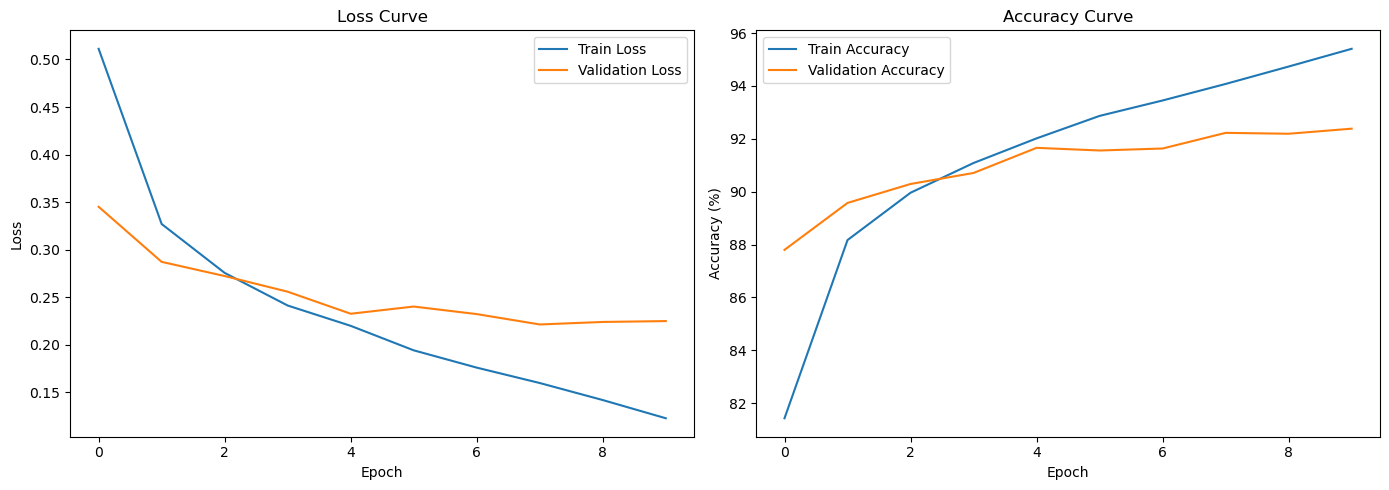

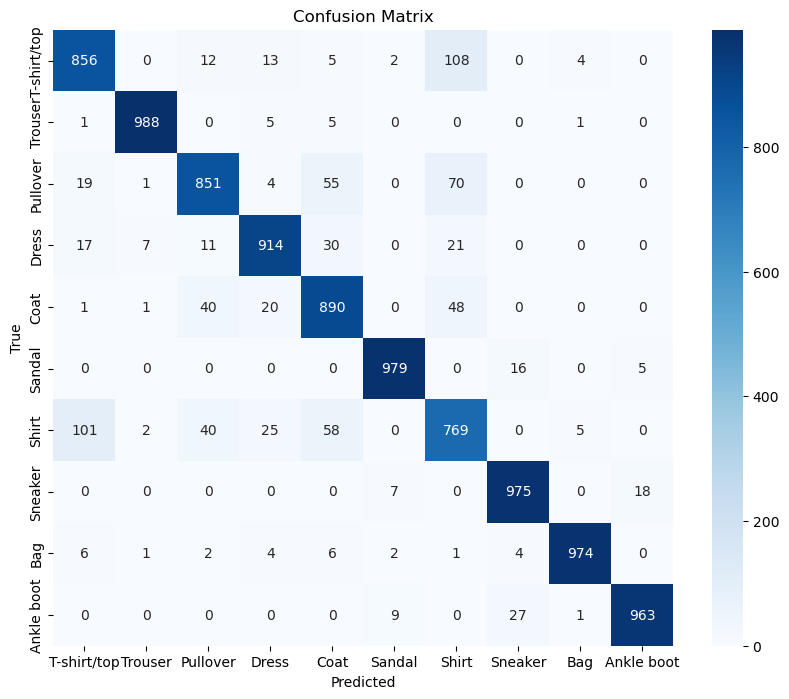


Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.86      0.86      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.89      0.85      0.87      1000
       Dress       0.93      0.91      0.92      1000
        Coat       0.85      0.89      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.76      0.77      0.76      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000


Final Test Accuracy: 91.59%


In [34]:
# Plot Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_title("Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

# Plot accuracy
ax2.plot(train_accuracies, label='Train Accuracy')
ax2.plot(val_accuracies, label='Validation Accuracy')
ax2.set_title("Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_data.classes

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Final test accuracy
test_accuracy = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"\nFinal Test Accuracy: {test_accuracy:.2f}%")


[Improved] Epoch 1/10: Train Loss=0.4268, Train Acc=84.74%, Val Loss=0.2770, Val Acc=89.90%
[Improved] Epoch 2/10: Train Loss=0.2891, Train Acc=89.46%, Val Loss=0.2370, Val Acc=91.26%
[Improved] Epoch 3/10: Train Loss=0.2530, Train Acc=90.71%, Val Loss=0.2173, Val Acc=92.08%
[Improved] Epoch 4/10: Train Loss=0.2263, Train Acc=91.69%, Val Loss=0.2052, Val Acc=92.68%
[Improved] Epoch 5/10: Train Loss=0.2073, Train Acc=92.37%, Val Loss=0.1689, Val Acc=93.88%
[Improved] Epoch 6/10: Train Loss=0.1884, Train Acc=92.88%, Val Loss=0.1588, Val Acc=94.33%
[Improved] Epoch 7/10: Train Loss=0.1762, Train Acc=93.47%, Val Loss=0.1501, Val Acc=94.62%
[Improved] Epoch 8/10: Train Loss=0.1627, Train Acc=94.02%, Val Loss=0.1534, Val Acc=94.41%
[Improved] Epoch 9/10: Train Loss=0.1510, Train Acc=94.31%, Val Loss=0.1242, Val Acc=95.72%
[Improved] Epoch 10/10: Train Loss=0.1405, Train Acc=94.73%, Val Loss=0.1425, Val Acc=94.67%


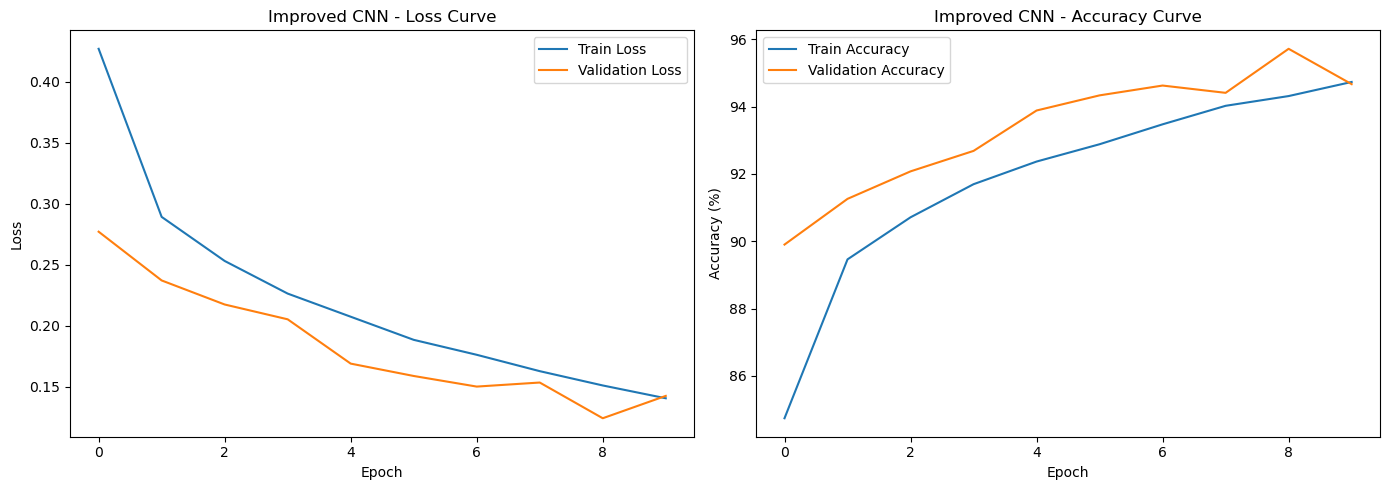

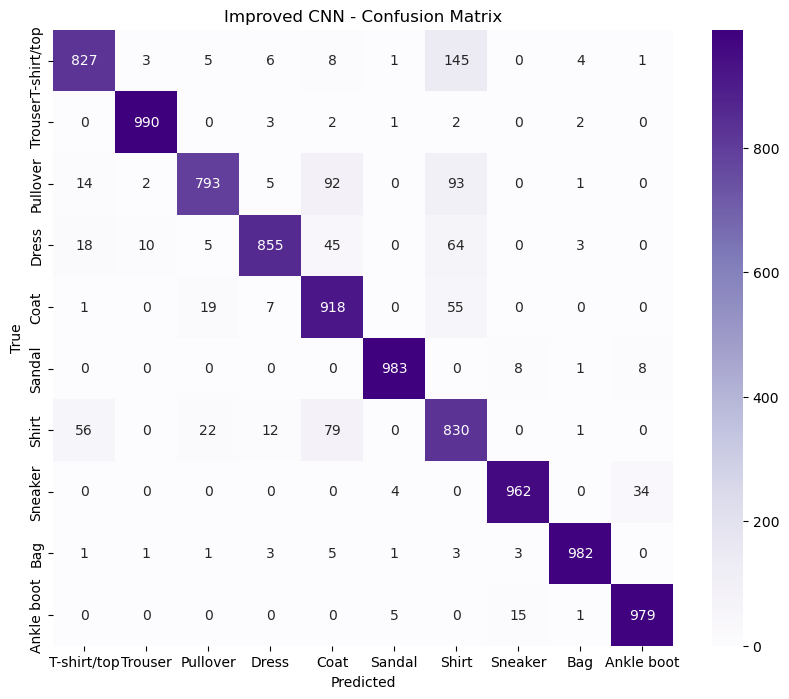


Classification Report (Improved CNN):
              precision    recall  f1-score   support

 T-shirt/top       0.90      0.83      0.86      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.94      0.79      0.86      1000
       Dress       0.96      0.85      0.90      1000
        Coat       0.80      0.92      0.85      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.70      0.83      0.76      1000
     Sneaker       0.97      0.96      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.96      0.98      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000


Improved CNN - Final Test Accuracy: 91.19%


In [35]:
# Data augmentation transform (for improved model training only)
augmented_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomRotation(3),
    transforms.ToTensor()
])

# Reload augmented training data (keep same validation/test)
aug_train_val_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=augmented_transform)
aug_train_data, _ = random_split(aug_train_val_data, [48000, 12000])  # match previous split size
aug_train_loader = DataLoader(aug_train_data, batch_size=64, shuffle=True)

# Train and evaluate the Improved CNN

# Initialize
improved_model = ImprovedCNN().to(device)
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.001)

# Track metrics
improved_train_losses, improved_val_losses = [], []
improved_train_accuracies, improved_val_accuracies = [], []

for epoch in range(num_epochs):
    improved_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in aug_train_loader:
        images, labels = images.to(device), labels.to(device)
        improved_optimizer.zero_grad()
        outputs = improved_model(images)
        loss = improved_criterion(outputs, labels)
        loss.backward()
        improved_optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(aug_train_loader)
    train_acc = 100 * correct_train / total_train

    improved_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = improved_model(images)
            loss = improved_criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val

    improved_train_losses.append(train_loss)
    improved_val_losses.append(val_loss)
    improved_train_accuracies.append(train_acc)
    improved_val_accuracies.append(val_acc)

    print(f"[Improved] Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.2f}%")

# Plot Improved Model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(improved_train_losses, label='Train Loss')
ax1.plot(improved_val_losses, label='Validation Loss')
ax1.set_title("Improved CNN - Loss Curve")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()

ax2.plot(improved_train_accuracies, label='Train Accuracy')
ax2.plot(improved_val_accuracies, label='Validation Accuracy')
ax2.set_title("Improved CNN - Accuracy Curve")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy (%)")
ax2.legend()

plt.tight_layout()
plt.show()

# Test evaluation
improved_model.eval()
improved_preds, improved_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = improved_model(images)
        _, predicted = torch.max(outputs, 1)
        improved_preds.extend(predicted.cpu().numpy())
        improved_labels.extend(labels.numpy())

# Confusion Matrix & Report
cm_improved = confusion_matrix(improved_labels, improved_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Improved CNN - Confusion Matrix')
plt.show()

print("\nClassification Report (Improved CNN):")
print(classification_report(improved_labels, improved_preds, target_names=class_names))

# Final Test Accuracy
improved_test_accuracy = (np.array(improved_preds) == np.array(improved_labels)).mean() * 100
print(f"\nImproved CNN - Final Test Accuracy: {improved_test_accuracy:.2f}%")



In [36]:
print("--- Model Comparison ---")
print(f"Baseline CNN - Test Accuracy: {test_accuracy:.2f}%")
print(f"Improved CNN - Test Accuracy: {improved_test_accuracy:.2f}%")
print(f"Accuracy Improvement: {improved_test_accuracy - test_accuracy:.2f}%")


--- Model Comparison ---
Baseline CNN - Test Accuracy: 91.59%
Improved CNN - Test Accuracy: 91.19%
Accuracy Improvement: -0.40%
